In [21]:
import os
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV, cross_validate
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, log_loss, make_scorer, brier_score_loss
from sklearn.calibration import calibration_curve,CalibratedClassifierCV
from sklearn.inspection import permutation_importance
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import spearmanr
from skopt import BayesSearchCV
from skopt.space import Real, Integer
import xgboost as xgb
import sklearn
import metrics
%matplotlib inline

In [2]:
#Mcfadden_r2: Value  for better fit- 0.2 to 0.4
def mcfadden_r2(y, y_pred):
    ll = log_loss(y, y_pred)
    ll_null = log_loss(y, np.full(len(y), y.mean()))
    return 1 - (ll/ll_null)
pseudo_r2_scorer = make_scorer(mcfadden_r2, needs_proba=True, greater_is_better=True)

In [3]:
scoring = {'roc_aug': 'roc_auc', 'mcfaddens_r2': pseudo_r2_scorer}

In [4]:
df=pd.read_pickle('E:/Athan/football data/xG_Model/ShotData/openplayshotsBig5_17-22.pkl')
df

,x,y,isGoal,isBigChance,isCounter,isFoot,dist,angle_rad,assistType,isPrevShot,playType
0,31.605,20.264,0,0,0,1,34.460901,0.194542,2,0,0
1,7.455,27.200,0,1,1,1,10.090442,0.552945,2,0,0
2,28.035,31.892,0,0,0,1,28.114140,0.258214,2,0,0
3,9.240,36.720,1,1,0,1,9.632030,0.705688,2,0,0
4,5.250,33.660,1,1,1,1,5.260998,1.214966,2,0,0
...,...,...,...,...,...,...,...,...,...,...,...
195323,3.780,29.104,0,1,0,1,6.185403,0.838761,0,0,0
195324,7.875,35.904,1,0,0,0,8.101904,0.834496,0,0,0
195325,8.610,28.220,0,0,0,1,10.370174,0.589926,0,0,0
195326,11.655,28.900,1,0,0,1,12.721990,0.521601,4,0,0


In [5]:
train_df=df[['x','y','isBigChance','isCounter','isFoot','dist',
            'angle_rad','assistType','isPrevShot']]
features=np.array(train_df)
goal=np.array(df['isGoal'])
features.shape,goal.shape

((195328, 9), (195328,))

In [6]:
X_train, X_test, y_train, y_test = train_test_split(features, goal, train_size=0.8, random_state=42, stratify=goal)

In [7]:
print('Shots train', len(y_train), ';Number goals', y_train.sum(),
      ';Goals %: ', round(y_train.mean()*100, 2))
print('Shots test', len(y_test), ';Number goals', y_test.sum(),
      ';Goals %: ', round(y_test.mean()*100, 2))

Shots train 156262 ;Number goals 16442 ;Goals %:  10.52
Shots test 39066 ;Number goals 4111 ;Goals %:  10.52


# TRAIN Calibrated XGBOOST MODEL

In [9]:
if __name__ == '__main__':
    fix_params = {'objective': 'binary:logistic','eval_metric':'logloss',
                 'use_label_encoder':False,'seed':42,'random_state':42}
    #              'n_jobs':-1}#,'tree_method':'gpu_hist'}
    xgclass= CalibratedClassifierCV(xgb.XGBClassifier(**fix_params), method='isotonic', cv=5)
    xgb_param_grid ={
            'base_estimator__learning_rate': Real(0.01, 1.0, 'log-uniform'),
            'base_estimator__min_child_weight': Integer(0, 10),
            'base_estimator__max_depth': Integer(1, 50),
            'base_estimator__max_delta_step': Integer(0, 20),
            'base_estimator__subsample': Real(0.01, 1, 'uniform'),
            'base_estimator__colsample_bytree': Real(0.01, 1.0, 'uniform'),
            'base_estimator__colsample_bylevel': Real(0.01, 1.0, 'uniform'),
            'base_estimator__reg_lambda': Real(1e-9, 1000, 'log-uniform'),
            'base_estimator__reg_alpha': Real(1e-9, 1.0, 'log-uniform'),
            'base_estimator__gamma': Real(1e-9, 0.5, 'log-uniform'),
            'base_estimator__min_child_weight': Integer(0, 5),
            'base_estimator__n_estimators': Integer(100,700),
            'base_estimator__scale_pos_weight': Real(1e-6, 200, 'log-uniform')
    }   
    # Nested resampling using skopt. see: https://github.com/scikit-optimize/scikit-optimize/issues/725
    searchcv = BayesSearchCV(estimator=xgclass,
                             n_iter=50, scoring='neg_log_loss',
                             search_spaces=xgb_param_grid,
                             cv=3,
                             n_jobs=-2,verbose=3,pre_dispatch='2*n_jobs')
    searchcv.fit(X_train, y_train)

Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fi

In [82]:
best_estimator=searchcv.best_estimator_
best_estimator

CalibratedClassifierCV(base_estimator=XGBClassifier(base_score=None,
                                                    booster=None,
                                                    callbacks=None,
                                                    colsample_bylevel=0.1421257912586683,
                                                    colsample_bynode=None,
                                                    colsample_bytree=0.6011839958587012,
                                                    early_stopping_rounds=None,
                                                    enable_categorical=False,
                                                    eval_metric='logloss',
                                                    gamma=1.7221319151331933e-09,
                                                    gpu_id=None,
                                                    grow_policy=None,
                                                    importance_type=None,
                                                    intera...ne,
                                                    learning_rate=0.07126927747846018,
                                                    max_bin=None,
                                                    max_cat_to_onehot=None,
                                                    max_delta_step=11,
                                                    max_depth=20,
                                                    max_leaves=None,
                                                    min_child_weight=0,
                                                    missing=nan,
                                                    monotone_constraints=None,
                                                    n_estimators=656,
                                                    n_jobs=None,
                                                    num_parallel_tree=None,
                                                    predictor=None,
                                                    random_state=42,
                                                    reg_alpha=7.468025754760358e-08,
                                                    reg_lambda=0.2576904736042836, ...),
                       cv=5, method='isotonic')

# Feature Importance

In [9]:
perm_result = permutation_importance(best_estimator, X_train, y_train, n_repeats=10, random_state=42,n_jobs=-2)
df_perm_importance = pd.DataFrame({'Feature':train_df.columns,
                                   'importance': perm_result.importances.mean(axis=1),
                                   'std_dev': perm_result.importances.std(axis=1)})
df_perm_importance.sort_values('importance', ascending=False, inplace=True)
df_perm_importance.reset_index(drop=True, inplace=True)
df_perm_importance

,Feature,importance,std_dev
0,angle_rad,0.005847,0.000264
1,assistType,0.004848,0.000242
2,isBigChance,0.004507,0.000123
3,dist,0.004167,0.000237
4,y,0.002816,0.000152
5,x,0.002470,0.000170
6,isCounter,0.001297,0.000097
7,isFoot,0.001250,0.000080
8,isPrevShot,0.000687,0.000062


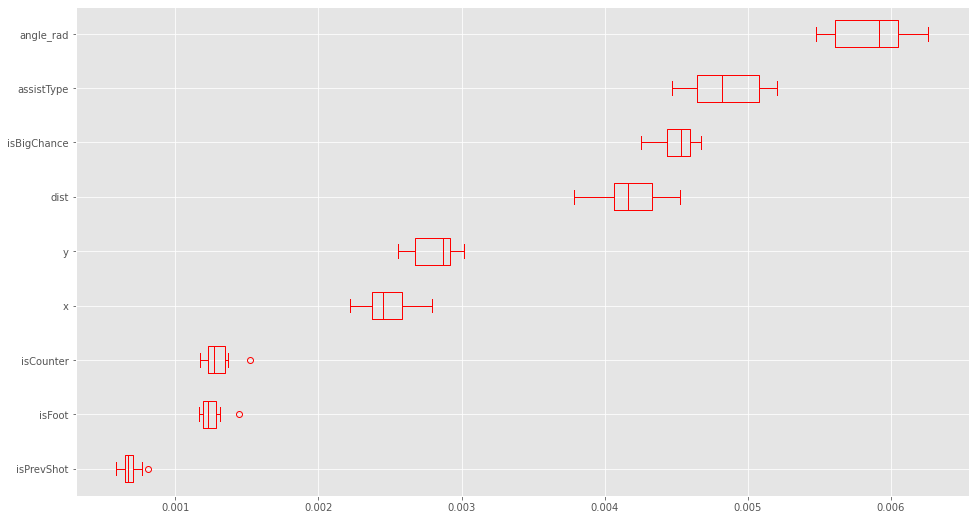

In [10]:
plt.style.use('ggplot')
fig, ax = plt.subplots(figsize=(16, 9))
sorted_idx = perm_result.importances_mean.argsort()
c='r'
bar_plot = ax.boxplot(perm_result.importances[sorted_idx].T, vert=False, labels=train_df.columns[sorted_idx]
                     ,boxprops=dict(color=c),capprops=dict(color=c),
            whiskerprops=dict(color=c),
            flierprops=dict(color=c, markeredgecolor=c),
            medianprops=dict(color=c))
plt.show()

# TEST

In [11]:
y_pred=best_estimator.predict(X_test)

In [13]:
from sklearn.metrics import mean_squared_error,accuracy_score,classification_report,confusion_matrix
print("Test Accuracy: ",accuracy_score(y_test,y_pred )*100)
print("Train Accuracy: ",accuracy_score(y_train, (best_estimator.predict(X_train)))*100)

Test Accuracy:  90.03993242205497
Train Accuracy:  90.46601221026225


In [14]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.91      0.99      0.95     34955
           1       0.65      0.11      0.20      4111

    accuracy                           0.90     39066
   macro avg       0.78      0.55      0.57     39066
weighted avg       0.88      0.90      0.87     39066



In [15]:
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
specificity = tn / (tn+fp)
sensitivity= tp/(tp+fn)
print("sensitivity is: ",sensitivity)
print("specificity is: ",specificity)

sensitivity is:  0.11481391388956458
specificity is:  0.9927907309397798


C:\Users\hp\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


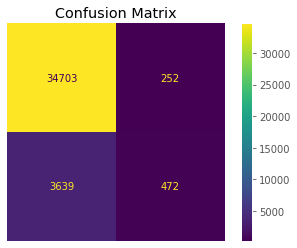

In [16]:
from sklearn.metrics import plot_confusion_matrix,log_loss,mean_squared_log_error
plot_confusion_matrix(best_estimator,X_test,y_test,cmap=plt.cm.viridis)
plt.title('Confusion Matrix')
plt.axis('off')
plt.show()

# Predicted Probablities Testing

In [17]:
y_pred_lgbm_calibrated = best_estimator.predict_proba(X_test)[:, 1]
fraction_of_positives_lgbm, mean_predicted_value_lgbm = calibration_curve(y_test, y_pred_lgbm_calibrated, n_bins=10)

In [18]:
print("Mean sqaured error is: %.4f" %mean_squared_error(y_test,y_pred_lgbm_calibrated))
print("Log Loss is: %.4f" %log_loss(y_test,y_pred_lgbm_calibrated))
print("Mean sqaured log error is: %.4f" %mean_squared_log_error(y_test,y_pred_lgbm_calibrated))

Mean sqaured error is: 0.0761
Log Loss is: 0.2647
Mean sqaured log error is: 0.0371


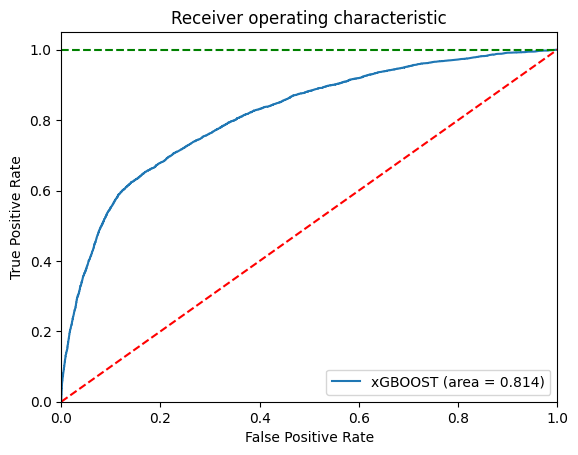

In [19]:
from sklearn.metrics import roc_curve,precision_score,recall_score,f1_score,roc_auc_score
logit_roc_auc = roc_auc_score(y_test,y_pred_lgbm_calibrated)
fpr, tpr, thresholds = roc_curve(y_test, y_pred_lgbm_calibrated)
plt.style.use('default')
plt.figure()
plt.plot(fpr, tpr, label='xGBOOST (area = %0.3f)' % logit_roc_auc)
plt.plot([0, 1], [1, 1],'g--')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
# plt.savefig('Log_ROC')
plt.show()

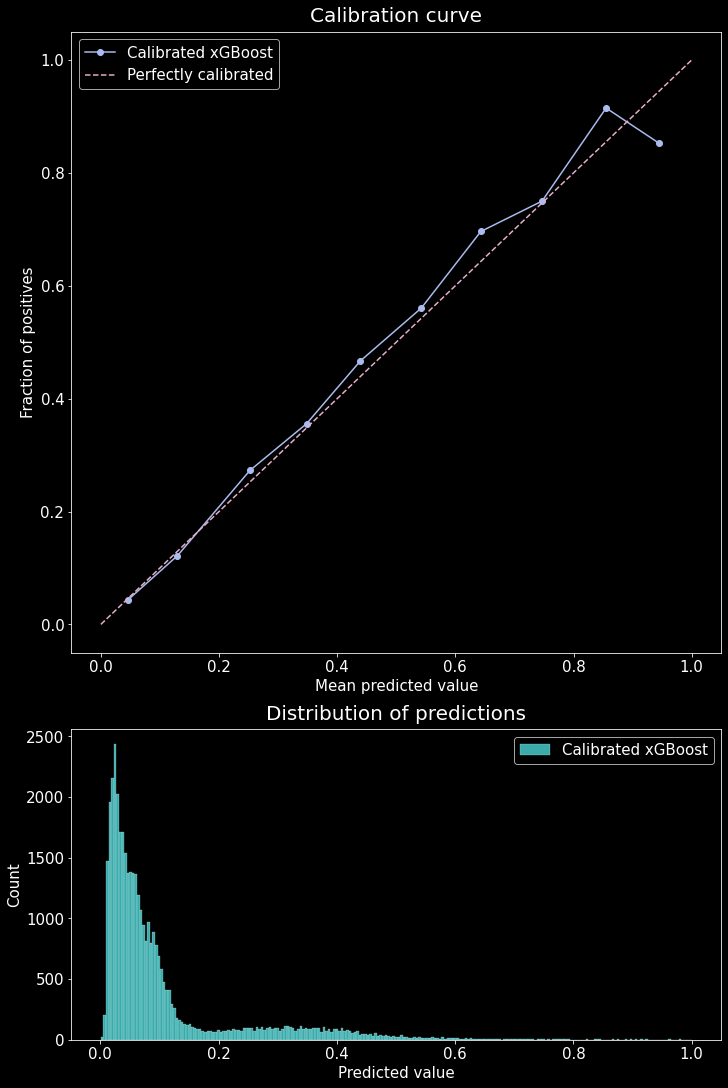

In [22]:
plt.style.use('dark_background')
fig = plt.figure(constrained_layout=True, figsize=(10, 15))
gs = fig.add_gridspec(ncols=1, nrows=2, height_ratios=(2/3, 1/3))
ax1 = fig.add_subplot(gs[0])
ax1.plot(mean_predicted_value_lgbm, fraction_of_positives_lgbm, "-o", color='#aabced', label='Calibrated xGBoost')
ax1.plot([0, 1], [0, 1], "--", color='#e7aeca', label="Perfectly calibrated")
ax1.set_xlabel('Mean predicted value', fontsize=15)
ax1.set_ylabel('Fraction of positives', fontsize=15)
ax1.set_title('Calibration curve', fontsize=20, pad=10)
ax1.legend(fontsize=15)
ax1.tick_params(labelsize=15)
ax2 = fig.add_subplot(gs[1])
sns.histplot(y_pred_lgbm_calibrated, color='#4fe4e4', label='Calibrated xGBoost', kde=False, ax=ax2)
ax2.set_xlabel('Predicted value', fontsize=15)
ax2.set_ylabel('Count', fontsize=15)
ax2.tick_params(labelsize=15)
ax2.legend(fontsize=15)
ax2.set_title('Distribution of predictions', fontsize=20, pad=10)
plt.show()

In [26]:
from metrics import expected_calibration_error
print('Brier score, xgboost:{:.4f}%'.format(brier_score_loss(y_test, y_pred_lgbm_calibrated, pos_label=y_test.max())*100))
print('ROC AUC, xgboost:{:.4f}'.format(roc_auc_score(y_test, y_pred_lgbm_calibrated)))
print('Mcfadden R-squared value, xgboost:{:.4f}'.format(mcfadden_r2(y_test, y_pred_lgbm_calibrated)))
print('Exp. Calibration Error:{:.4f}%'.format(expected_calibration_error(y_test,y_pred_lgbm_calibrated)*100))

Brier score, xgboost:7.6059%
ROC AUC, xgboost:0.8143
Mcfadden R-squared value, xgboost:0.2132
Exp. Calibration Error:0.5100%


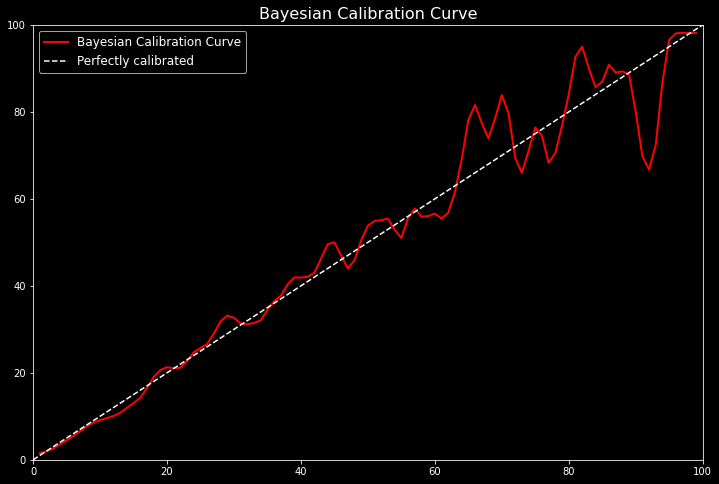

In [32]:
tprob,pred_prob,n=metrics.bayesian_calibration_curve(y_test, y_pred_lgbm_calibrated)
plt.figure(figsize=(12,8))
plt.title("Bayesian Calibration Curve",color='w',fontsize=16)
plt.plot(tprob,pred_prob,lw=2,color='r', label="Bayesian Calibration Curve")
plt.plot([0, 100], [0, 100],'--',color='w', label="Perfectly calibrated")
plt.legend(fontsize=12)
# plt.text(75,10,"Max deviation:{:.4f}% \nArea under the bayesian curve:{:.4f}".format(
#     metrics.max_deviation(tprob,pred_prob), metrics.residual_area(tprob,pred_prob)))
plt.xlim([0,100])
plt.ylim([0,100])
plt.show()

In [30]:
print("Max deviation:{:.4f}%".format(metrics.max_deviation(tprob,pred_prob)))
print("Area under the bayesian curve:{:.4f}".format(metrics.residual_area(tprob,pred_prob)))

Max deviation:25.2933%
Area under the bayesian curve:366.9349


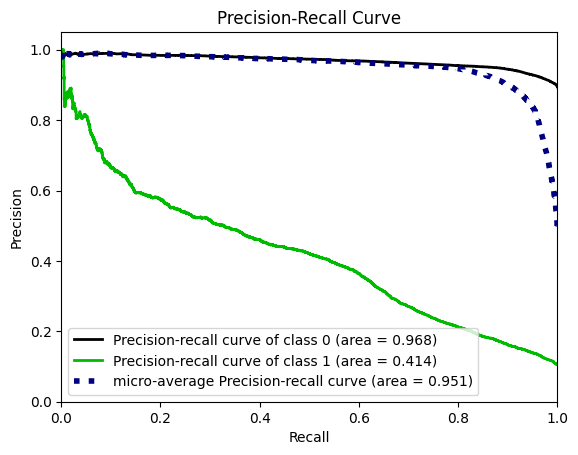

In [33]:
plt.style.use('default')
y_probas = best_estimator.predict_proba(X_test)
plot_precision_recall(y_test,y_probas)
plt.show()

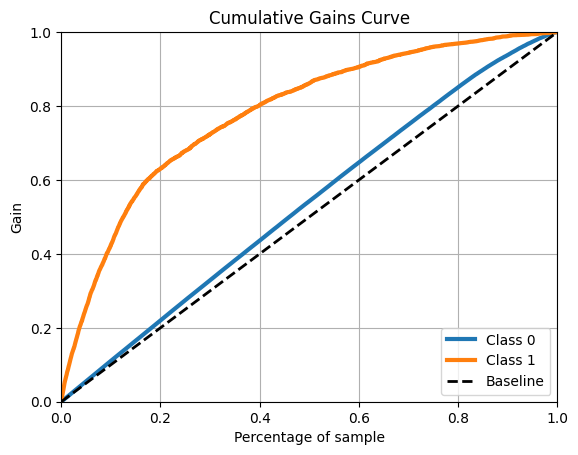

In [34]:
plot_cumulative_gain(y_test,y_probas)
plt.show()

C:\Users\hp\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_precision_recall_curve is deprecated; Function `plot_precision_recall_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: PrecisionRecallDisplay.from_predictions or PrecisionRecallDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


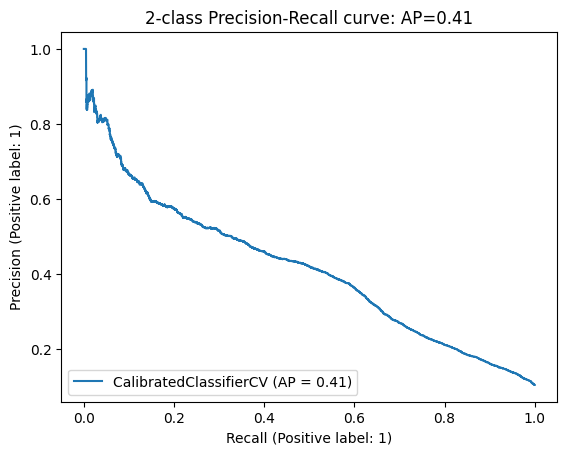

In [35]:
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import plot_precision_recall_curve
from sklearn.metrics import average_precision_score
average_precision = average_precision_score(y_test, y_pred_lgbm_calibrated)
disp = plot_precision_recall_curve(best_estimator, X_test, y_test)
disp.ax_.set_title('2-class Precision-Recall curve: '
                   'AP={0:0.2f}'.format(average_precision))
plt.show()

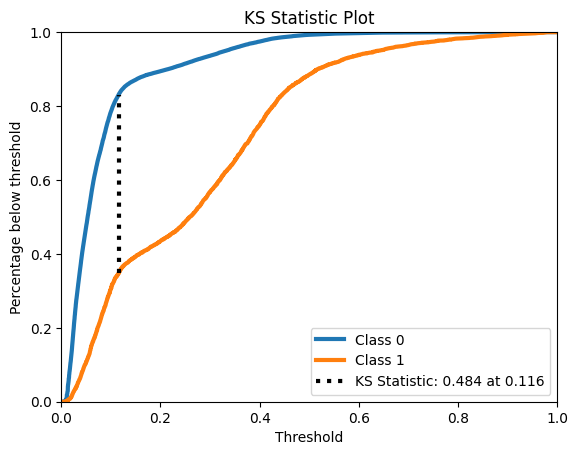

In [36]:
plot_ks_statistic(y_test,y_probas)
plt.show()

In [26]:
import joblib
#SAVE MODEL
joblib.dump(searchcv.best_estimator_, 'E:\\Athan\\football data\\xG_Model\\Model\\calibrated_xgboost_openplay_model16-22.joblib')

['E:\\Athan\\football data\\xG_Model\\Model\\calibrated_xgboost_openplay_model16-22.joblib']